<a href="https://colab.research.google.com/github/tmtakashi/GAN_MNIST/blob/master/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://qiita.com/triwave33/items/1890ccc71fab6cbca87e
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from keras.models import Sequential
from keras.optimizers import Adam

import numpy as np

class GAN():
  def __init__(self):
    # MNISTの入力サイズ
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)

    # 潜在変数の次元数
    self.z_dim =100

    optimizer = Adam(0.0002, 0.5)

    # Discriminatorモデル
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy',
                               optimizer=optimizer,
                               metrics=['accuracy'])

    # Generatorモデル
    self.generator = self.build_generator()
    # Generatorは単体では学習しないのでコンパイルは必要ない

    self.combined = self.build_combined1()
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
  def build_generator(self):
    noise_shape = (self.z_dim, )
    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))


    model.summary()

    return model

  def build_discriminator(self):
    img_shape = (self.img_rows, self.img_cols, self.channels)

    model = Sequential()
    
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    return model

  def build_combined1(self):
    self.discriminator.trainable = False
    model = Sequential([self.generator, self.discriminator])
    return model

  def build_combined2(self):
    z = Input(shape=(self.z_dim,))
    img = self.generator(z)
    self.discriminator.trainable = False
    valid = self.discriminator(img)
    model = Model(z, valid)
    model.summary()
    return model

  def train(self, iterations, batch_size=128, save_interval=50):

    #　MNIST読み込み
    from keras.datasets import mnist
    (x_train, _), (_, _) = mnist.load_data()

    # 正規化
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    # チャンネル次元を増やす
    x_train = np.expand_dims(x_train, axis=3)

    half_batch = int(batch_size / 2)

    for i in range(iterations):

      # -------------------------
      # Discriminatorの学習
      # -------------------------

      # バッチサイズの半数をGeneratorから生成
      noise = np.random.normal(0, 1, (half_batch, self.z_dim))
      gen_imgs = self.generator.predict(noise)

      # バッチサイズの半数を教師データからピックアップ
      idx = np.random.randint(0, x_train.shape[0], half_batch)
      imgs = x_train[idx]

      # Discriminatorを学習
      # 本物データと偽物データは別々に学習させる
      d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))) # 本物
      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))) # 偽物
      # それぞれの損失関数を平均
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      # -----------------------
      # Generatorの学習
      # -----------------------

      noise = np.random.normal(0, 1, (batch_size, self.z_dim))

      # 生成データの正解データは本物
      valid_y = np.array([1] * batch_size)

      # Generatorを学習
      g_loss = self.combined.train_on_batch(noise, valid_y)

      # 進捗の表示
      if i % 100 == 0:
        print("%d [ D loss: %f, acc.: %2.f%%] [G loss: %f]" % (i, d_loss[0], 100*d_loss[1], g_loss))

In [0]:
# https://qiita.com/triwave33/items/1890ccc71fab6cbca87e
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from keras.models import Sequential
from keras.optimizers import Adam

import numpy as np

# Generatorの学習率を半分にした
class GAN2():
  def __init__(self):
    # MNISTの入力サイズ
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)

    # 潜在変数の次元数
    self.z_dim =100

    optimizer = Adam(0.0002, 0.5)

    # Discriminatorモデル
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy',
                               optimizer=optimizer,
                               metrics=['accuracy'])

    # Generatorモデル
    self.generator = self.build_generator()
    # Generatorは単体では学習しないのでコンパイルは必要ない

    self.combined = self.build_combined1()
    self.combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5))
    
  def build_generator(self):
    noise_shape = (self.z_dim, )
    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))


    model.summary()

    return model

  def build_discriminator(self):
    img_shape = (self.img_rows, self.img_cols, self.channels)

    model = Sequential()
    
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    return model

  def build_combined1(self):
    self.discriminator.trainable = False
    model = Sequential([self.generator, self.discriminator])
    return model

  def build_combined2(self):
    z = Input(shape=(self.z_dim,))
    img = self.generator(z)
    self.discriminator.trainable = False
    valid = self.discriminator(img)
    model = Model(z, valid)
    model.summary()
    return model

  def train(self, iterations, batch_size=128, save_interval=50):

    #　MNIST読み込み
    from keras.datasets import mnist
    (x_train, _), (_, _) = mnist.load_data()

    # 正規化
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    # チャンネル次元を増やす
    x_train = np.expand_dims(x_train, axis=3)

    half_batch = int(batch_size / 2)

    for i in range(iterations):

      # -------------------------
      # Discriminatorの学習
      # -------------------------

      # バッチサイズの半数をGeneratorから生成
      noise = np.random.normal(0, 1, (half_batch, self.z_dim))
      gen_imgs = self.generator.predict(noise)

      # バッチサイズの半数を教師データからピックアップ
      idx = np.random.randint(0, x_train.shape[0], half_batch)
      imgs = x_train[idx]

      # Discriminatorを学習
      # 本物データと偽物データは別々に学習させる
      d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))) # 本物
      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))) # 偽物
      # それぞれの損失関数を平均
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      # -----------------------
      # Generatorの学習
      # -----------------------

      noise = np.random.normal(0, 1, (batch_size, self.z_dim))

      # 生成データの正解データは本物
      valid_y = np.array([1] * batch_size)

      # Generatorを学習
      g_loss = self.combined.train_on_batch(noise, valid_y)

      # 進捗の表示
      if i % 100 == 0:
        print("%d [ D loss: %f, acc.: %2.f%%] [G loss: %f]" % (i, d_loss[0], 100*d_loss[1], g_loss))

In [0]:
model1 = GAN()
model1.train(iterations=400)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_24 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_162 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_116 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_163 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_117 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_164 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.747896, acc.: 37%] [G loss: 0.609424]
100 [ D loss: 0.294659, acc.: 87%] [G loss: 2.858519]
200 [ D loss: 0.284766, acc.: 88%] [G loss: 2.380563]
300 [ D loss: 0.732825, acc.: 38%] [G loss: 0.633048]


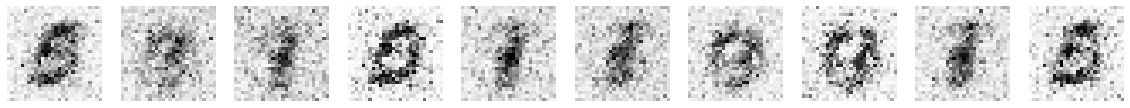

In [72]:
# 400 iteration
generated_img = model1.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt
from matplotlib import cm

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]), cmap=cm.gray_r)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [0]:
model1_2 = GAN2()
model1_2.train(iterations=400)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_25 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_169 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_121 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_170 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_122 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_171 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 1.001056, acc.: 16%] [G loss: 0.727168]
100 [ D loss: 0.009225, acc.: 100%] [G loss: 4.588662]
200 [ D loss: 0.015147, acc.: 100%] [G loss: 5.844211]
300 [ D loss: 0.071434, acc.: 97%] [G loss: 4.469321]


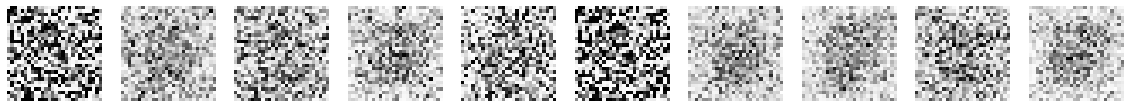

In [0]:
# 400 iteration
generated_img = model1_2.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [0]:
model2 = GAN()
model2.train(iterations=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_26 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_176 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_126 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_177 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_127 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_178 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.579890, acc.: 88%] [G loss: 0.976100]
100 [ D loss: 0.395755, acc.: 81%] [G loss: 3.065552]
200 [ D loss: 0.742285, acc.: 45%] [G loss: 1.042838]
300 [ D loss: 0.642656, acc.: 49%] [G loss: 0.630607]
400 [ D loss: 0.628894, acc.: 53%] [G loss: 0.696641]
500 [ D loss: 0.627208, acc.: 61%] [G loss: 0.715309]
600 [ D loss: 0.637929, acc.: 57%] [G loss: 0.772213]
700 [ D loss: 0.621030, acc.: 69%] [G loss: 0.837311]
800 [ D loss: 0.634590, acc.: 65%] [G loss: 0.832303]
900 [ D loss: 0.596522, acc.: 78%] [G loss: 0.843299]


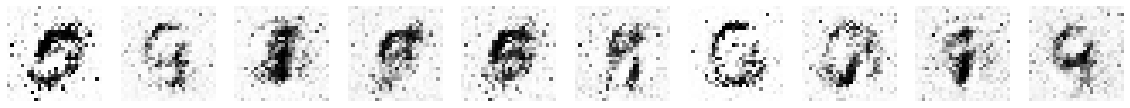

In [0]:
# 1000 iteration
generated_img = model2.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [0]:
model2_2 = GAN2()
model2_2.train(iterations=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_27 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_183 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_131 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_184 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_132 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_185 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.563644, acc.: 50%] [G loss: 0.430898]
100 [ D loss: 0.006996, acc.: 100%] [G loss: 4.689290]
200 [ D loss: 0.007665, acc.: 100%] [G loss: 6.078606]
300 [ D loss: 0.229163, acc.: 89%] [G loss: 4.254116]
400 [ D loss: 0.060946, acc.: 99%] [G loss: 4.965930]
500 [ D loss: 0.172822, acc.: 97%] [G loss: 3.622560]
600 [ D loss: 0.523151, acc.: 72%] [G loss: 1.817476]
700 [ D loss: 0.654575, acc.: 41%] [G loss: 0.833353]
800 [ D loss: 0.583282, acc.: 70%] [G loss: 0.877191]
900 [ D loss: 0.557499, acc.: 72%] [G loss: 0.988122]


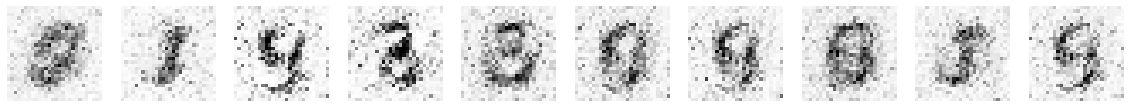

In [0]:
# 1000 iteration
generated_img = model2_2.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [0]:
model3 = GAN()
model3.train(iterations=5000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_28 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_190 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_136 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_191 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_137 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_192 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.927477, acc.: 12%] [G loss: 0.739093]
100 [ D loss: 0.076805, acc.: 98%] [G loss: 3.369800]
200 [ D loss: 0.703316, acc.: 50%] [G loss: 1.506006]
300 [ D loss: 0.664791, acc.: 44%] [G loss: 0.656641]
400 [ D loss: 0.630708, acc.: 50%] [G loss: 0.686807]
500 [ D loss: 0.648331, acc.: 56%] [G loss: 0.712361]
600 [ D loss: 0.646077, acc.: 55%] [G loss: 0.728948]
700 [ D loss: 0.647960, acc.: 71%] [G loss: 0.792264]
800 [ D loss: 0.629228, acc.: 74%] [G loss: 0.823910]
900 [ D loss: 0.605813, acc.: 73%] [G loss: 0.905337]
1000 [ D loss: 0.638363, acc.: 68%] [G loss: 0.885090]
1100 [ D loss: 0.583967, acc.: 73%] [G loss: 0.892133]
1200 [ D loss: 0.589517, acc.: 71%] [G loss: 0.940167]
1300 [ D loss: 0.601011, acc.: 68%] [G loss: 0.996167]
1400 [ D loss: 0.588154, acc.: 69%] [G loss: 1.008994]
1500 [ D loss: 0.581995, acc.: 74%] [G loss: 1.058121]
1600 [ D loss: 0.557433, acc.: 72%] [G loss: 1.049194]
1700 [ D loss: 0.602294, acc.: 70%] [G loss: 0.999134]
1800 [ D loss: 0.59547

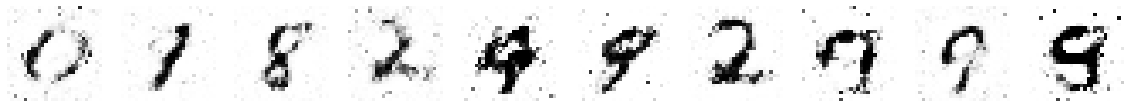

In [0]:
# 5000 iteration
generated_img = model3.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [0]:
model3_2 = GAN2()
model3_2.train(iterations=5000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_29 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_197 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_141 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_198 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_142 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_199 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.509729, acc.: 69%] [G loss: 0.662502]
100 [ D loss: 0.006470, acc.: 100%] [G loss: 4.994946]
200 [ D loss: 0.028363, acc.: 99%] [G loss: 5.909078]
300 [ D loss: 0.018587, acc.: 100%] [G loss: 4.969736]
400 [ D loss: 0.089123, acc.: 97%] [G loss: 4.766222]
500 [ D loss: 1.682472, acc.: 42%] [G loss: 1.411841]
600 [ D loss: 0.693497, acc.: 52%] [G loss: 1.125471]
700 [ D loss: 0.602183, acc.: 51%] [G loss: 0.876046]
800 [ D loss: 0.551100, acc.: 76%] [G loss: 0.954399]
900 [ D loss: 0.621804, acc.: 62%] [G loss: 0.896598]
1000 [ D loss: 0.599653, acc.: 74%] [G loss: 0.913927]
1100 [ D loss: 0.563350, acc.: 78%] [G loss: 1.096593]
1200 [ D loss: 0.558701, acc.: 70%] [G loss: 1.047740]
1300 [ D loss: 0.557900, acc.: 79%] [G loss: 1.077705]
1400 [ D loss: 0.553448, acc.: 73%] [G loss: 1.047556]
1500 [ D loss: 0.514433, acc.: 88%] [G loss: 1.164392]
1600 [ D loss: 0.514782, acc.: 90%] [G loss: 1.089789]
1700 [ D loss: 0.535197, acc.: 81%] [G loss: 1.121719]
1800 [ D loss: 0.554

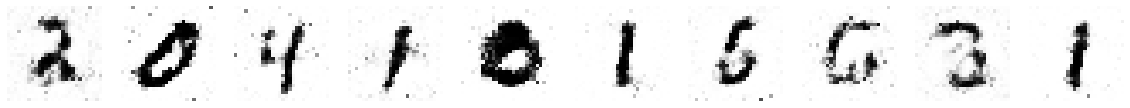

In [0]:
# 5000 iteration
generated_img = model3_2.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [0]:
model4 = GAN()
model4.train(iterations=10000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_30 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_204 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_146 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_205 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_147 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_206 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.688018, acc.: 40%] [G loss: 0.456502]
100 [ D loss: 0.129828, acc.: 98%] [G loss: 2.768251]
200 [ D loss: 0.595513, acc.: 66%] [G loss: 1.456319]
300 [ D loss: 0.659692, acc.: 45%] [G loss: 0.659998]
400 [ D loss: 0.660461, acc.: 48%] [G loss: 0.671194]
500 [ D loss: 0.607176, acc.: 65%] [G loss: 0.739329]
600 [ D loss: 0.640049, acc.: 73%] [G loss: 0.803869]
700 [ D loss: 0.627784, acc.: 64%] [G loss: 0.861111]
800 [ D loss: 0.588965, acc.: 73%] [G loss: 0.913851]
900 [ D loss: 0.595060, acc.: 77%] [G loss: 0.895734]
1000 [ D loss: 0.602739, acc.: 62%] [G loss: 1.008671]
1100 [ D loss: 0.579397, acc.: 77%] [G loss: 0.922507]
1200 [ D loss: 0.533428, acc.: 80%] [G loss: 1.107588]
1300 [ D loss: 0.528851, acc.: 77%] [G loss: 1.212529]
1400 [ D loss: 0.528401, acc.: 80%] [G loss: 1.187187]
1500 [ D loss: 0.533363, acc.: 79%] [G loss: 1.173144]
1600 [ D loss: 0.619466, acc.: 66%] [G loss: 1.056687]
1700 [ D loss: 0.614252, acc.: 69%] [G loss: 1.110266]
1800 [ D loss: 0.58281

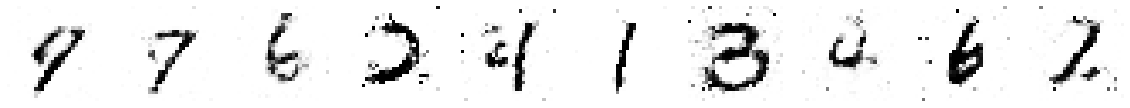

In [0]:
# 10000 iteration
generated_img = model4.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [0]:
model5 = GAN()
model5.train(iterations=15000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_31 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_211 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_151 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_212 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_152 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_213 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.510307, acc.: 52%] [G loss: 0.466528]
100 [ D loss: 0.101246, acc.: 96%] [G loss: 3.595296]
200 [ D loss: 0.745141, acc.: 55%] [G loss: 1.294195]
300 [ D loss: 0.700539, acc.: 45%] [G loss: 0.654180]
400 [ D loss: 0.660469, acc.: 49%] [G loss: 0.679797]
500 [ D loss: 0.629486, acc.: 57%] [G loss: 0.762093]
600 [ D loss: 0.626537, acc.: 72%] [G loss: 0.781556]
700 [ D loss: 0.631903, acc.: 59%] [G loss: 0.758344]
800 [ D loss: 0.629639, acc.: 73%] [G loss: 0.835311]
900 [ D loss: 0.584199, acc.: 72%] [G loss: 0.871023]
1000 [ D loss: 0.577381, acc.: 70%] [G loss: 0.966257]
1100 [ D loss: 0.592700, acc.: 68%] [G loss: 0.956439]
1200 [ D loss: 0.596321, acc.: 70%] [G loss: 0.971515]
1300 [ D loss: 0.614238, acc.: 69%] [G loss: 1.008450]
1400 [ D loss: 0.599371, acc.: 72%] [G loss: 0.944655]
1500 [ D loss: 0.586460, acc.: 68%] [G loss: 0.931168]
1600 [ D loss: 0.630707, acc.: 64%] [G loss: 0.925670]
1700 [ D loss: 0.596562, acc.: 69%] [G loss: 0.943522]
1800 [ D loss: 0.58360

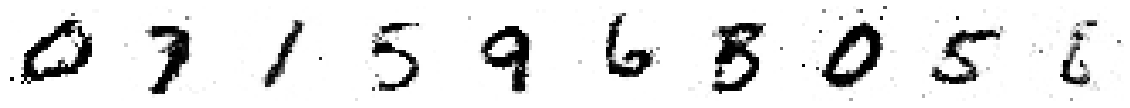

In [0]:
# 15000 iteration
generated_img = model5.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [70]:
model6 = GAN()
model6.train(iterations=20000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_32 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_218 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_156 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_219 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_157 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_220 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.859098, acc.: 23%] [G loss: 0.810461]
100 [ D loss: 0.184406, acc.: 92%] [G loss: 2.653923]
200 [ D loss: 0.376683, acc.: 80%] [G loss: 2.666037]
300 [ D loss: 0.692843, acc.: 51%] [G loss: 0.817884]
400 [ D loss: 0.659273, acc.: 54%] [G loss: 0.709060]
500 [ D loss: 0.647953, acc.: 62%] [G loss: 0.719957]
600 [ D loss: 0.620709, acc.: 73%] [G loss: 0.784511]
700 [ D loss: 0.590882, acc.: 70%] [G loss: 0.852482]
800 [ D loss: 0.627284, acc.: 64%] [G loss: 1.039543]
900 [ D loss: 0.619023, acc.: 66%] [G loss: 0.898487]
1000 [ D loss: 0.593895, acc.: 68%] [G loss: 0.974674]
1100 [ D loss: 0.552919, acc.: 79%] [G loss: 0.989799]
1200 [ D loss: 0.601187, acc.: 66%] [G loss: 0.940993]
1300 [ D loss: 0.656268, acc.: 55%] [G loss: 0.908544]
1400 [ D loss: 0.592711, acc.: 67%] [G loss: 0.979043]
1500 [ D loss: 0.586646, acc.: 67%] [G loss: 1.017310]
1600 [ D loss: 0.575933, acc.: 73%] [G loss: 0.978625]
1700 [ D loss: 0.623671, acc.: 69%] [G loss: 0.940105]
1800 [ D loss: 0.58120

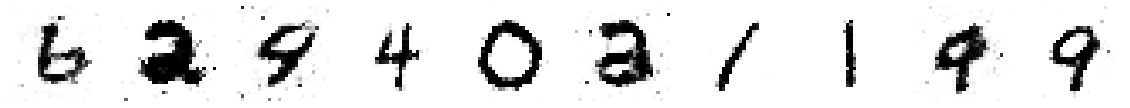

In [71]:
# 20000 iteration
generated_img = model6.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [0]:
model7_2 = GAN2()
model7_2.train(iterations=2350)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_114 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_82 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_115 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.692481, acc.: 49%] [G loss: 0.719333]
100 [ D loss: 0.027070, acc.: 100%] [G loss: 5.218693]
200 [ D loss: 0.247102, acc.: 88%] [G loss: 4.959448]
300 [ D loss: 0.108805, acc.: 98%] [G loss: 5.428639]
400 [ D loss: 0.267028, acc.: 89%] [G loss: 6.059778]
500 [ D loss: 0.212363, acc.: 94%] [G loss: 4.683022]
600 [ D loss: 0.266924, acc.: 89%] [G loss: 4.593657]
700 [ D loss: 0.219963, acc.: 95%] [G loss: 4.228265]
800 [ D loss: 0.484494, acc.: 73%] [G loss: 3.430533]
900 [ D loss: 0.493229, acc.: 74%] [G loss: 2.648318]
1000 [ D loss: 0.710682, acc.: 55%] [G loss: 1.450107]
1100 [ D loss: 0.731959, acc.: 47%] [G loss: 0.966905]
1200 [ D loss: 0.751765, acc.: 53%] [G loss: 0.865674]
1300 [ D loss: 0.651131, acc.: 58%] [G loss: 0.994169]
1400 [ D loss: 0.681374, acc.: 57%] [G loss: 0.803143]
1500 [ D loss: 0.728386, acc.: 43%] [G loss: 0.806042]
1600 [ D loss: 0.735734, acc.: 39%] [G loss: 0.717829]
1700 [ D loss: 0.722390, acc.: 40%] [G loss: 0.690172]
1800 [ D loss: 0.7122

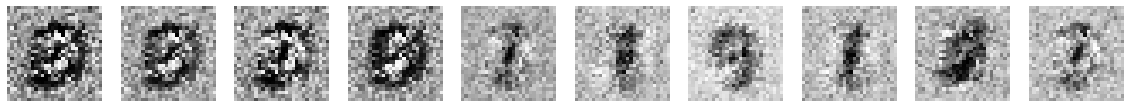

In [0]:
# 2350 iteration
generated_img = model7_2.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [0]:
model8_2 = GAN2()
model8_2.train(iterations=2500)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_19 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_127 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_91 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_128 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_92 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.840133, acc.: 12%] [G loss: 0.499155]
100 [ D loss: 0.135506, acc.: 98%] [G loss: 5.251735]
200 [ D loss: 0.220055, acc.: 93%] [G loss: 3.816821]
300 [ D loss: 0.175737, acc.: 96%] [G loss: 5.577044]
400 [ D loss: 0.200806, acc.: 95%] [G loss: 6.011683]
500 [ D loss: 0.329577, acc.: 85%] [G loss: 5.515742]
600 [ D loss: 0.206913, acc.: 95%] [G loss: 4.752378]
700 [ D loss: 0.223543, acc.: 92%] [G loss: 5.167992]
800 [ D loss: 0.410656, acc.: 78%] [G loss: 4.798611]
900 [ D loss: 0.418900, acc.: 86%] [G loss: 9.849486]
1000 [ D loss: 0.354207, acc.: 88%] [G loss: 3.442149]
1100 [ D loss: 0.665624, acc.: 59%] [G loss: 3.251129]
1200 [ D loss: 0.563384, acc.: 77%] [G loss: 1.488337]
1300 [ D loss: 0.683345, acc.: 58%] [G loss: 1.153106]
1400 [ D loss: 0.732908, acc.: 45%] [G loss: 0.888618]
1500 [ D loss: 0.734634, acc.: 45%] [G loss: 0.790725]
1600 [ D loss: 0.767671, acc.: 37%] [G loss: 0.704691]
1700 [ D loss: 0.697467, acc.: 52%] [G loss: 0.732009]
1800 [ D loss: 0.69891

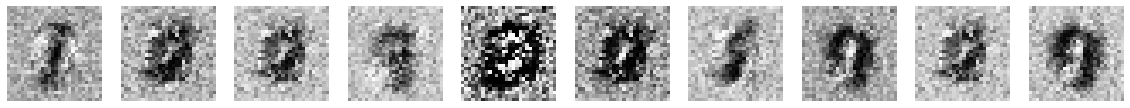

In [0]:
# 2500 iteration
generated_img = model7_2.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [0]:
model8_2 = GAN2()
model8_2.train(iterations=3000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_20 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_134 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_96 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_135 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_97 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_136 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.777755, acc.: 25%] [G loss: 0.782503]
100 [ D loss: 0.063241, acc.: 98%] [G loss: 5.626876]
200 [ D loss: 0.191777, acc.: 94%] [G loss: 4.530465]
300 [ D loss: 0.588526, acc.: 70%] [G loss: 6.870896]
400 [ D loss: 0.405925, acc.: 78%] [G loss: 6.650031]
500 [ D loss: 0.327621, acc.: 87%] [G loss: 5.488986]
600 [ D loss: 0.240274, acc.: 94%] [G loss: 5.352954]
700 [ D loss: 0.282840, acc.: 91%] [G loss: 4.778746]
800 [ D loss: 0.364346, acc.: 85%] [G loss: 3.745922]
900 [ D loss: 0.469243, acc.: 80%] [G loss: 2.872111]
1000 [ D loss: 0.424926, acc.: 77%] [G loss: 2.128238]
1100 [ D loss: 0.601105, acc.: 71%] [G loss: 1.795692]
1200 [ D loss: 0.550353, acc.: 75%] [G loss: 1.169546]
1300 [ D loss: 0.660186, acc.: 57%] [G loss: 0.810078]
1400 [ D loss: 0.655412, acc.: 52%] [G loss: 0.657782]
1500 [ D loss: 0.717030, acc.: 45%] [G loss: 0.637889]
1600 [ D loss: 0.696943, acc.: 45%] [G loss: 0.641320]
1700 [ D loss: 0.700683, acc.: 50%] [G loss: 0.638519]
1800 [ D loss: 0.71399

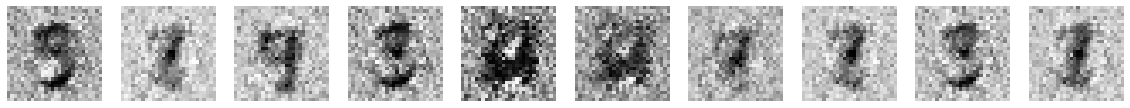

In [0]:
# 3000 iteration
generated_img = model8_2.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [0]:
model9_2 = GAN2()
model9_2.train(iterations=2500, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_21 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_141 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_101 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_142 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_102 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_143 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.676982, acc.: 47%] [G loss: 0.556270]
100 [ D loss: 0.021442, acc.: 100%] [G loss: 4.981421]
200 [ D loss: 0.133375, acc.: 94%] [G loss: 6.435952]
300 [ D loss: 0.244417, acc.: 88%] [G loss: 5.134871]
400 [ D loss: 0.128942, acc.: 94%] [G loss: 4.917216]
500 [ D loss: 0.301350, acc.: 84%] [G loss: 6.089986]
600 [ D loss: 0.226762, acc.: 88%] [G loss: 7.115685]
700 [ D loss: 0.144833, acc.: 100%] [G loss: 7.444065]
800 [ D loss: 0.070900, acc.: 100%] [G loss: 5.946494]
900 [ D loss: 0.083232, acc.: 100%] [G loss: 7.373552]
1000 [ D loss: 0.085425, acc.: 100%] [G loss: 6.551744]
1100 [ D loss: 0.045421, acc.: 100%] [G loss: 4.829608]
1200 [ D loss: 0.579682, acc.: 66%] [G loss: 5.167418]
1300 [ D loss: 0.345239, acc.: 88%] [G loss: 3.083328]
1400 [ D loss: 0.491656, acc.: 78%] [G loss: 2.546399]
1500 [ D loss: 0.367131, acc.: 88%] [G loss: 2.301947]
1600 [ D loss: 0.806676, acc.: 56%] [G loss: 1.074842]
1700 [ D loss: 0.714434, acc.: 59%] [G loss: 1.274412]
1800 [ D loss: 0

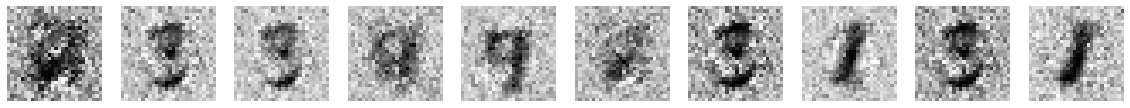

In [0]:
# 2500 iteration (batch_size=32)
generated_img = model8_2.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [0]:
model10_2 = GAN2()
model10_2.train(iterations=2100, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_22 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_148 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_106 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_149 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_107 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_150 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.575580, acc.: 94%] [G loss: 0.729779]
100 [ D loss: 0.021501, acc.: 100%] [G loss: 5.216165]
200 [ D loss: 0.141217, acc.: 97%] [G loss: 7.465649]
300 [ D loss: 0.191991, acc.: 94%] [G loss: 7.359333]
400 [ D loss: 0.204335, acc.: 97%] [G loss: 8.118046]
500 [ D loss: 0.233275, acc.: 91%] [G loss: 7.489642]
600 [ D loss: 0.261906, acc.: 91%] [G loss: 8.188657]
700 [ D loss: 0.063150, acc.: 100%] [G loss: 7.788261]
800 [ D loss: 0.103977, acc.: 97%] [G loss: 8.582926]
900 [ D loss: 0.064652, acc.: 100%] [G loss: 5.852764]
1000 [ D loss: 0.199288, acc.: 91%] [G loss: 6.798057]
1100 [ D loss: 0.128305, acc.: 97%] [G loss: 5.133689]
1200 [ D loss: 0.445246, acc.: 78%] [G loss: 4.462423]
1300 [ D loss: 0.204859, acc.: 97%] [G loss: 4.152351]
1400 [ D loss: 0.145963, acc.: 97%] [G loss: 4.294809]
1500 [ D loss: 0.738873, acc.: 56%] [G loss: 2.401284]
1600 [ D loss: 0.819341, acc.: 53%] [G loss: 1.261831]
1700 [ D loss: 0.774782, acc.: 41%] [G loss: 0.885451]
1800 [ D loss: 0.68

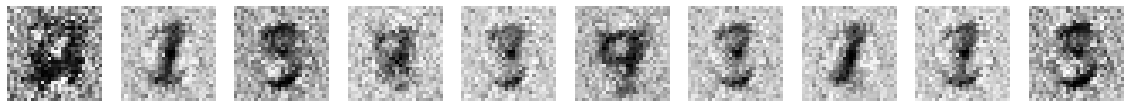

In [0]:
# 2100 iteration (batch_size=32)
generated_img = model8_2.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [0]:
model11_2 = GAN2()
model11_2.train(iterations=2200, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_23 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_155 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_111 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_156 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_112 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_157 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.743138, acc.: 22%] [G loss: 0.583702]
100 [ D loss: 0.012457, acc.: 100%] [G loss: 4.615963]
200 [ D loss: 0.171596, acc.: 94%] [G loss: 6.488935]
300 [ D loss: 0.070881, acc.: 100%] [G loss: 5.815603]
400 [ D loss: 0.127216, acc.: 97%] [G loss: 5.630217]
500 [ D loss: 0.145712, acc.: 97%] [G loss: 6.443603]
600 [ D loss: 0.132047, acc.: 97%] [G loss: 6.600257]
700 [ D loss: 0.111340, acc.: 97%] [G loss: 7.300223]
800 [ D loss: 0.068260, acc.: 100%] [G loss: 6.338525]
900 [ D loss: 0.188912, acc.: 97%] [G loss: 7.955338]
1000 [ D loss: 0.152380, acc.: 97%] [G loss: 6.048872]
1100 [ D loss: 0.318626, acc.: 91%] [G loss: 5.233749]
1200 [ D loss: 0.174156, acc.: 91%] [G loss: 4.540445]
1300 [ D loss: 0.415987, acc.: 84%] [G loss: 4.515197]
1400 [ D loss: 0.445570, acc.: 84%] [G loss: 2.470899]
1500 [ D loss: 0.677816, acc.: 53%] [G loss: 1.465839]
1600 [ D loss: 0.671956, acc.: 53%] [G loss: 1.079598]
1700 [ D loss: 0.689087, acc.: 66%] [G loss: 1.068193]
1800 [ D loss: 0.74

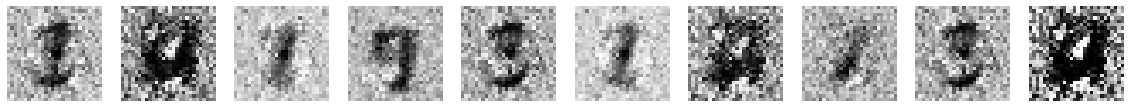

In [0]:
# 2200 iteration (batch_size=32)
generated_img = model8_2.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)